<a href="https://colab.research.google.com/github/IANovoselov/well/blob/main/well.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1727]:
import numpy as np
import pandas as pd
import random


In [1728]:
 # Исходные данные для моделировния

# Фонтанирующая скважина
# p_R = 28  # Среднепластовое давление
# p_G0 = 25  # Давление насыщенного газа

# Нефонтанирующая скважина
p_R = 21.65  # Среднепластовое давление
p_G0 = 17.32  # Давление насыщенного газа

H_R = 3000  # Глубина забоя по вертикали
w_1 = 12  # Гидропроводность из пласта в ПЗ скважины
w_2 = 60  # Гидропроводность из ПЗ в забой
betta = 0.3  # Объёмная доля воды
p_0 = 0.1  # Атмосферное давление

# Удельный вес
gamma_oil = 0.0068  # нефти
gamma_water = 0.011  # воды
gamma_gas = 0.000008  # газа
G = 100  # Газовый фактор
p_L_avg = 1.5  # Давление в линии нефтесбора

p_L = p_L_avg
p_L_rand = p_L_avg

# Гидросопротивление
r_K = 0.5  # обсадной колонный
r_N = 4  # НКТ
r_T = 0.8  # затрубного пространства
r_U = 3  # устьевого штуцера
r_GU = 3  # перепускного клапана

# Параметры насоса
H_N = 2000  # уровень подвеса
q_0 = 90  # номинальный дебит

# Напорная характеристика
q_Pump = [5/3, 4/3, 2/3]
lambda_0 = [10/3, 2, 3/2]
lambda_1 = [2, 1, 1/4]
lambda_2 = [0.5, 0.82, 0.74]
lambda_3 = [0.42, 0.18, 0.3]


S_t = 0.01  # Площадь поперечного сечени НКТ
T_2 = 0.4  # Постоянна времени притока
t_N = 0.01  # Постоянная времени насоса

In [1729]:
# Моделируемые данные, начальные условия
_q_N = []
_q_T = []
_q_L = []
__q = []
_p_1 = []
_p_2 = []
_p_3 = []
___p_3 = []
_p_5 = []
_p_4 = []
_p_8 = []
_u = []
_h_4 = []
_betta_G3 = []
_betta_GN = []
_N_1 = []
_N_2 = []
_count = []
_n_NN = []
_agzu = []
_r_U = []
_p_L = []
_q = []

In [1730]:
# Статический расчёт скважины

# Гидросопротивления
r_1 = 1/w_1  # Пласт - ПЗ
r_2 = 1/w_2  # ПЗ - забой
r_R = r_1 + r_2
r_1 = 0.083
r_2 = 0.017
r_R = 0.1

In [1731]:
# Ограничения
h_lim = 100  # По уровню над приёмом насос
betta_G_lim = 0.25  # По газу у первой ступени

In [1732]:
# Высота столба жидкости
gamma = (1-betta)*gamma_oil+betta*gamma_water
dH_R =  (p_R-p_L)/gamma - H_R
dH_R

-500.0

In [1733]:
h_0 = q_0*(r_U + r_N + r_K + r_R/gamma) - dH_R
h_0 = 2300

In [1734]:
alpha_G_3 = 0.4
alpha_betta = 0.333
k_S = 0.7
X_G = 0.00008

M_R3 = (1-betta)*G*((alpha_G_3*p_0) / (p_G0 - p_0))
M_R3 = 0.16
p_G3 = p_G0 * (((1-k_S)*M_R3)/(((1-k_S)*M_R3)+alpha_betta))

a_GU = 0.0000091 #k_S*X_G*M_R3

In [1735]:
# Расчёт динамики

# Начальные условия

M_q = 0.5

h_4 = H_N + dH_R
p_2 = p_R
t = 0
w = 1
q = 90
q_L = 90
dq = 90
p_3 = p_L + gamma * h_4

agzu_on = False
agzu_timer = 0
r_U_summ = 0

# Если запсукаем не из нуля
p_1 = 12.63
p_2 = 20.116
p_3 = 4.207
p_4 = 1.532
h_4 = 332

epsilon = 0.00001 * p_3


# Сегмент напорной характеристики
i = 1
k = 35000
dt = 0.0001  # Суток

# Статика при вариации частоты
_N_1 = []
_N_2 = []
_count = []
_n_NN = []


In [1736]:
dk = 24 * 60 * 60 * dt  # Секунд в одной итерации
dk

8.64

In [1737]:
# Начало расчёта
for _k in range(k):
    q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
    p_4 = (p_L + (p_G0 - p_3) * r_GU * np.sqrt(w) * a_GU * q)
    __p_3 = p_4 + gamma * h_4
    # Балансировка притока по начальным условиям
    while abs(p_3 - __p_3) > epsilon:
        p_3 = (1-M_q)*p_3 + M_q*__p_3
        q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
        p_4 = (p_L + (p_G0 - p_3) * r_GU * np.sqrt(w) * a_GU * q)
        __p_3 = p_4 + gamma * h_4
    p_3 = __p_3
    p_8 =p_L + gamma*r_U*q_L

    if _k == 0:
      dq = q

    # Расчёт подачи

    q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
    q_N = max(q_N, 0)

    if i > 0 and q_N > w*q_0*q_Pump[i]:
      i-=1
      i = max(i, 0)
      q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
      q_N = max(q_N, 0)

    if i < 2 and  q_N < w*q_0*q_Pump[i+1]:
      i+=1
      q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
      q_N = max(q_N, 0)




    M_RS = (1 - k_S*np.sqrt(w))* M_R3
    betta_G3 = (M_R3*(p_G0 - p_3)) / (p_3 + M_RS*(p_G0 - p_3))
    betta_GN = (M_RS*(p_G0 - p_3)) / (p_3 + M_RS*(p_G0 - p_3))


    p_1 = p_2 - r_1*q
    p_5 = p_8 + gamma*(H_N+r_N*q_N)


    h_N = h_0*(w*w*lambda_0[i]-w*lambda_1[i]*(q_N/q_0))
    n_N = 0.5
    N_1_0 = (gamma*h_0*q_0)/n_N
    N_2 = gamma * h_N * q_N
    alpha_n_L =0.1
    alpha_n_R =0.07
    w_n_L = 0.96
    w_n_R = 1.04
    delta_n_N = alpha_n_L * max(w_n_L-w, 0) + alpha_n_R * max(w-w_n_R, 0)
    N_1 = N_1_0*(1+delta_n_N)*(w*w*w*lambda_2[i] + w*w*lambda_3[i]*(q_N/q_0))
    n_NN = N_2/N_1

    _p_1.append(p_1)
    _p_3.append(p_3)
    _p_4.append(p_4)
    _p_8.append(p_8)
    _q_N.append(q_N)
    __q.append(q)
    _q_L.append(q_L)
    _h_4.append(h_4)
    _u.append(w)
    _p_5.append(p_5)
    _N_1.append(N_1)
    _N_2.append(N_2)
    _n_NN.append(n_NN)
    _betta_G3.append(betta_G3)
    _betta_GN.append(betta_GN)
    _agzu.append(agzu_on)
    _r_U.append(r_U)
    _p_L.append(p_L)
    _q.append(dq)


    p_L_change = random.randint(700, 800)

    if _k > 0 and _k % p_L_change == 0 and agzu_on is False:
      p_L_rand = random.uniform(0.9 * p_L_avg, 1.1 * p_L_avg)

    # Каждые 12 часов включатся АГЗУ на 30 минут
    if _k > 0 and _k % (5000 + 600) == 0:
      agzu_on = True
      agzu_timer = 0
      p_L_rand = 0.8 * p_L_avg

    if agzu_on is True:
      agzu_timer += 1
      r_U_summ += (p_8 - p_L)

    if agzu_on is True and agzu_timer == 417:
      agzu_on = False
      agzu_timer = 0

      # if not (_k * dt > 0.6 and _k * dt < 1.4) and not (_k * dt > 1.6 and _k * dt < 2.4) and not (_k * dt > 2.6 and _k * dt < 3.4):
      #     r_U = (r_U_summ/417) / (gamma*q_L)

      r_U_summ = 0
      p_L_rand = random.uniform(0.9 * p_L_avg, 1.1 * p_L_avg)

    # Шаг по Эйлеру
    p_2 = p_2 + (dt/T_2)*(p_R - p_2 - r_2*q)
    h_4 = h_4 + (dt/S_t)*(q-q_N)
    q_L = q_L + (dt/t_N)*(q_N-q_L)
    p_L = p_L + (dt/(dt*100))*(p_L_rand - p_L)
    dq = dq + (dt/T_2)*(q - dq)


    if _k * dt == 1:
      w = 0.9
    if _k * dt == 2:
      w = 1.1
    if _k * dt == 3:
      w = 1

In [1738]:
x = np.linspace(0, k*dt, k)

In [1739]:
df = pd.DataFrame({'q_N': _q_N, 'p_3': _p_3, 'p_1': _p_1, 'q': __q, 'h_4': _h_4, 'u': _u, 'x': x, 'dq': _q,
                   'p_4': _p_4, 'p_8': _p_8, 'p_5': _p_5, 'N_1': _N_1, 'N_2': _N_2, 'n_NN': _n_NN,
                   'betta_G3': _betta_G3, 'betta_GN': _betta_GN, 'q_L': _q_L, 'agzu': _agzu, 'r_U': _r_U, 'p_L': _p_L})
df[:100]

,q_N,p_3,p_1,q,h_4,u,x,dq,p_4,p_8,p_5,N_1,N_2,n_NN,betta_G3,betta_GN,q_L,agzu,r_U,p_L
0,90.203167,4.208198,12.631563,90.173945,332.000000,1.0,0.0000,90.173945,1.532278,3.676200,22.704350,3338.195873,1668.411498,0.499794,0.433666,0.130100,90.000000,False,3,1.5
1,90.202950,4.208195,12.631597,90.173529,331.999708,1.0,0.0001,90.173945,1.532278,3.676249,22.704392,3338.194424,1668.411516,0.499795,0.433667,0.130100,90.002032,False,3,1.5
2,90.202736,4.208193,12.631595,90.173562,331.999414,1.0,0.0002,90.173945,1.532278,3.676298,22.704434,3338.192997,1668.411534,0.499795,0.433667,0.130100,90.004041,False,3,1.5
3,90.202525,4.208191,12.631593,90.173592,331.999122,1.0,0.0003,90.173944,1.532278,3.676346,22.704475,3338.191586,1668.411552,0.499795,0.433667,0.130100,90.006028,False,3,1.5
4,90.202316,4.208188,12.631590,90.173621,331.998832,1.0,0.0004,90.173944,1.532278,3.676393,22.704516,3338.190190,1668.411569,0.499795,0.433667,0.130100,90.007993,False,3,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,90.190335,4.208038,12.631447,90.175632,331.979996,1.0,0.0095,90.173962,1.532279,3.679097,22.706833,3338.110235,1668.412538,0.499808,0.433685,0.130106,90.119791,False,3,1.5
96,90.190258,4.208037,12.631446,90.175649,331.979849,1.0,0.0096,90.173962,1.532279,3.679114,22.706848,3338.109724,1668.412544,0.499808,0.433685,0.130106,90.120497,False,3,1.5
97,90.190183,4.208035,12.631444,90.175665,331.979703,1.0,0.0097,90.173963,1.532279,3.679130,22.706862,3338.109219,1668.412550,0.499808,0.433685,0.130106,90.121194,False,3,1.5
98,90.190108,4.208034,12.631443,90.175681,331.979558,1.0,0.0098,90.173963,1.532279,3.679147,22.706876,3338.108719,1668.412556,0.499808,0.433686,0.130106,90.121884,False,3,1.5


In [1740]:
k_s = 0
static = [[], [], []]
for index, row in df.iterrows():
  q = row['q']
  dq = row['dq']
  if q == dq:
    k_s += 1
    static[0].append(index)
    static[1].append(q)
    static[2].append(dq)

print(k_s)

1


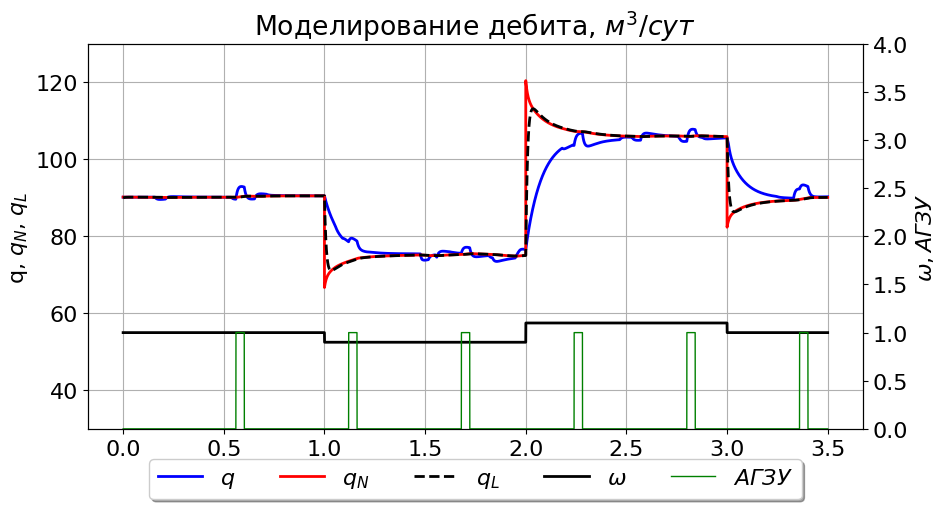

In [1741]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
twin1 = ax.twinx()
#twin2 = ax.twinx()
#twin2.spines.right.set_position(("axes", 1.1))

plt.rcParams.update({'font.size': 16})

p1, = ax.plot(df['x'], df['q'], 'b', lw=2, label="$q$")
p2, = ax.plot(df['x'], df['q_N'], 'r', lw=2, label="$q_N$")
p3, = ax.plot(df['x'], df['q_L'], 'k--', lw=2, label="$q_L$")

p4, = twin1.plot(df['x'],  df['u'],'k', lw=2, label="$\omega$")
p5, = twin1.plot(df['x'],  df['agzu'],'g', lw=1, label="$АГЗУ$")
#p6, = twin2.plot(df['x'],  df['r_U'],'y', lw=2, label="$r_U$")


ax.set(ylim=(30, 130), xlabel="Сутки", ylabel="q, $q_N$, $q_L$")
twin1.set(ylim=(0, 4), ylabel="$\omega, АГЗУ$")
#twin2.set(ylim=(2.9, 3.1), ylabel="$r_U$")

plt.title('Моделирование дебита, $м^3/сут$')


ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=6, handles=[p1, p2, p3, p4, p5])
ax.grid()
plt.show()

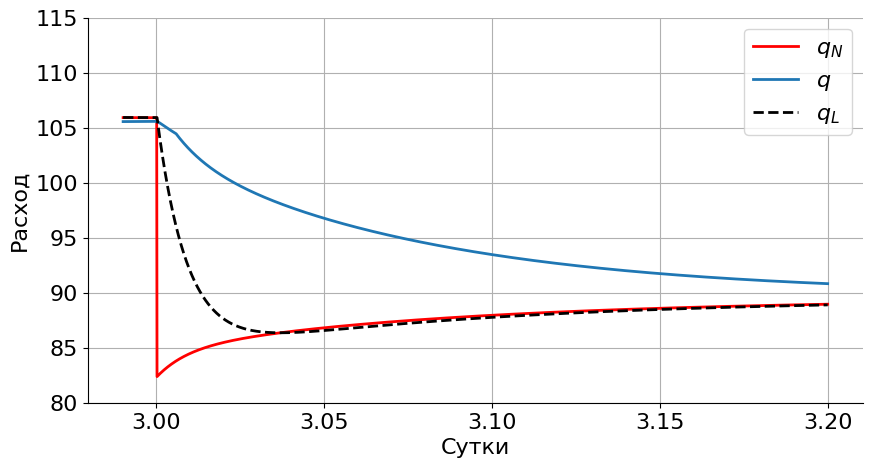

In [1742]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.gca().spines[['top', 'right']].set_visible(False)
# plot one by one

plt.plot(df['x'][29900:32000], df['q_N'][29900:32000], 'r', lw=2, label='$q_N$')
plt.plot(df['x'][29900:32000], df['q'][29900:32000], lw=2, label='$q$')
plt.plot(df['x'][29900:32000], df['q_L'][29900:32000], 'k--', lw=2, label='$q_L$')



# set x label
plt.xlabel('Сутки')
plt.ylabel('Расход')


plt.ylim(80, 115)
plt.grid(True)

plt.legend()

# display plot
plt.show()

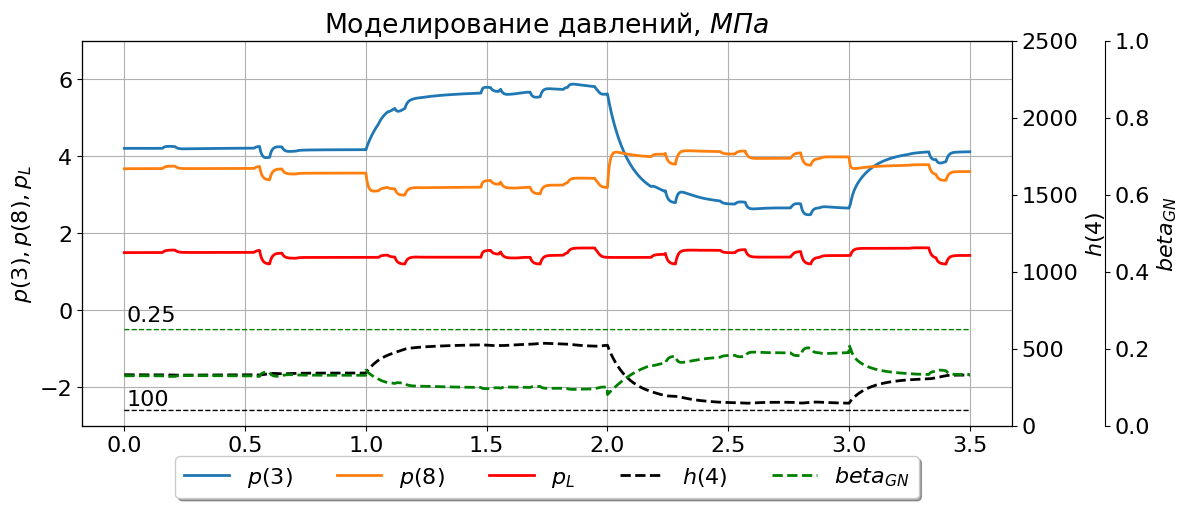

In [1743]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12, 5))

twin1 = ax.twinx()
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.1))
plt.rcParams.update({'font.size': 16})

p1, = ax.plot(df['x'], df['p_3'], lw=2, label="$p(3)$")
p2, = ax.plot(df['x'], df['p_8'], lw=2, label="$p(8)$")
p3, = ax.plot(df['x'], df['p_L'], 'r', lw=2, label="$p_L$")

p4, = twin1.plot(df['x'],  df['h_4'],'k--', lw=2, label="$h(4)$")

p5, = twin1.plot(df['x'],  [h_lim]*k,'k--', lw=1)
twin1.annotate(h_lim, xy = (df['x'][100], h_lim*1.3 ))

p5, = twin2.plot(df['x'],  df['betta_GN'],'g--', lw=2, label="$beta_{GN}$")
p6, = twin2.plot(df['x'],  [betta_G_lim]*k,'g--', lw=1)
twin2.annotate(betta_G_lim, xy = (df['x'][100], betta_G_lim*1.08 ))


ax.set(ylim=(-3, 7), xlabel="Сутки", ylabel="$p(3), p(8), p_L$")
twin1.set(ylim=(0, 2500), ylabel="$h(4)$")
twin2.set(ylim=(0, 1), ylabel="$beta_{GN}$")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, handles=[p1, p2, p3, p4, p5])

plt.title('Моделирование давлений, $МПа$')
ax.grid()
plt.show()

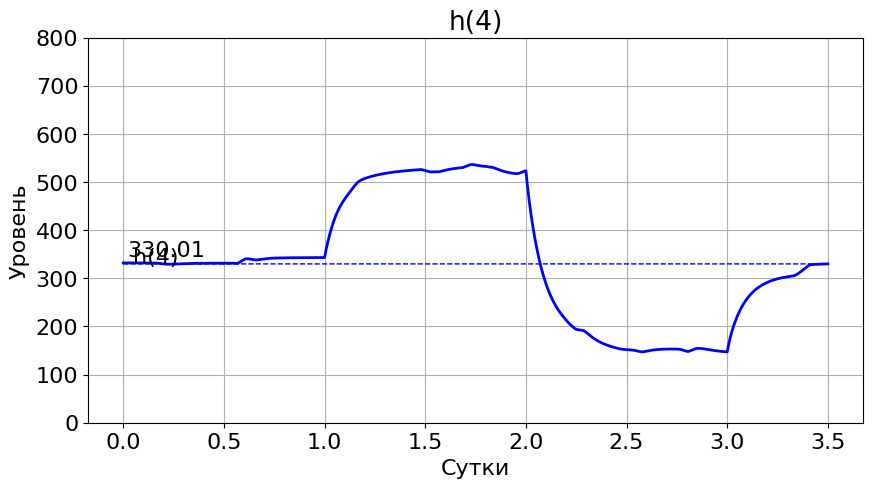

In [1744]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))

plt.plot(df['x'], df['h_4'],'b', lw=2)
plt.plot(df['x'], [df['h_4'][k-1]]*k,'b--', lw=1)

plt.annotate('h(4)', xy = (df['x'][500],df['h_4'][200] ))
plt.annotate(str(df['h_4'][k-1].round(2)), xy = (df['x'][200], df['h_4'][k-1]*1.05))

# set x label
plt.xlabel('Сутки')
plt.ylabel('Уровень')

# set title
plt.title('h(4)')
plt.ylim(0, 800)
plt.grid(True)
plt.show()

In [1745]:
min_p = 0
max_p = 100
points = 1000

quant = np.linspace(min_p, max_p, points)
quant_step = (max_p - min_p) / points
quant_step

0.1

In [1746]:
from datetime import datetime, timedelta

sample_interval_min = dt * 24 * 60  # интервал между измерениями в минутах
start_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
duration_hours = 3.5 * 24      # длительность в часах
n = int(duration_hours * 60 / sample_interval_min)  # количество измерений
n

34999

In [1747]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from datetime import datetime, timedelta

def get_with_error(val, hf_amplitude=1):
  return val *random.uniform(-hf_amplitude, hf_amplitude)

def generate_hf_noise(arr, hf_amplitude):
  return [get_with_error(val, hf_amplitude=hf_amplitude) if i%5==0 else 0 for i, val in enumerate(arr)]


def add_pressure_noise_daily(clean_data, sample_interval_min=sample_interval_min,
                            lf_amplitude=0.05, hf_amplitude=0.01,
                            lf_cutoff=1, hf_cutoff=0.01, random_seed=None):
    """
    Добавляет низкочастотный и высокочастотный шум к данным давления с привязкой к суточному времени

    Параметры:
    clean_data - массив чистых данных давления
    sample_interval_min - интервал между измерениями в минутах
    lf_amplitude - амплитуда низкочастотного шума (доля от диапазона данных)
    hf_amplitude - амплитуда высокочастотного шума (доля от диапазона данных)
    lf_cutoff - частота среза для НЧ шума (в циклах в минуту)
    hf_cutoff - частота среза для ВЧ шума (в циклах в минуту)
    random_seed - зерно для генератора случайных чисел

    Возвращает:
    noisy_data - зашумленные данные
    lf_noise - низкочастотный шум
    hf_noise - высокочастотный шум
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    n = len(clean_data)
    data_range = np.max(clean_data) - np.min(clean_data)


    # Рассчитываем частоту дискретизации в циклах в минуту
    fs = 1.0 / dt  # частота дискретизации (циклов в минуту)

    # 1. Генерация низкочастотного шума (дрейф)
    # Для суточных данных НЧ шум должен быть очень низкочастотным
    b, a = signal.butter(2, lf_cutoff / (fs/2), 'low')
    lf_noise = signal.lfilter(b, a, np.random.randn(n))
    lf_noise = lf_amplitude * data_range * (lf_noise / np.max(np.abs(lf_noise)))

    # 2. Генерация высокочастотного шума
    hf_noise = generate_hf_noise(clean_data, hf_amplitude)

    # 3. Комбинация шумов с чистыми данными
    noisy_data = clean_data + lf_noise + hf_noise

    return noisy_data, lf_noise, hf_noise

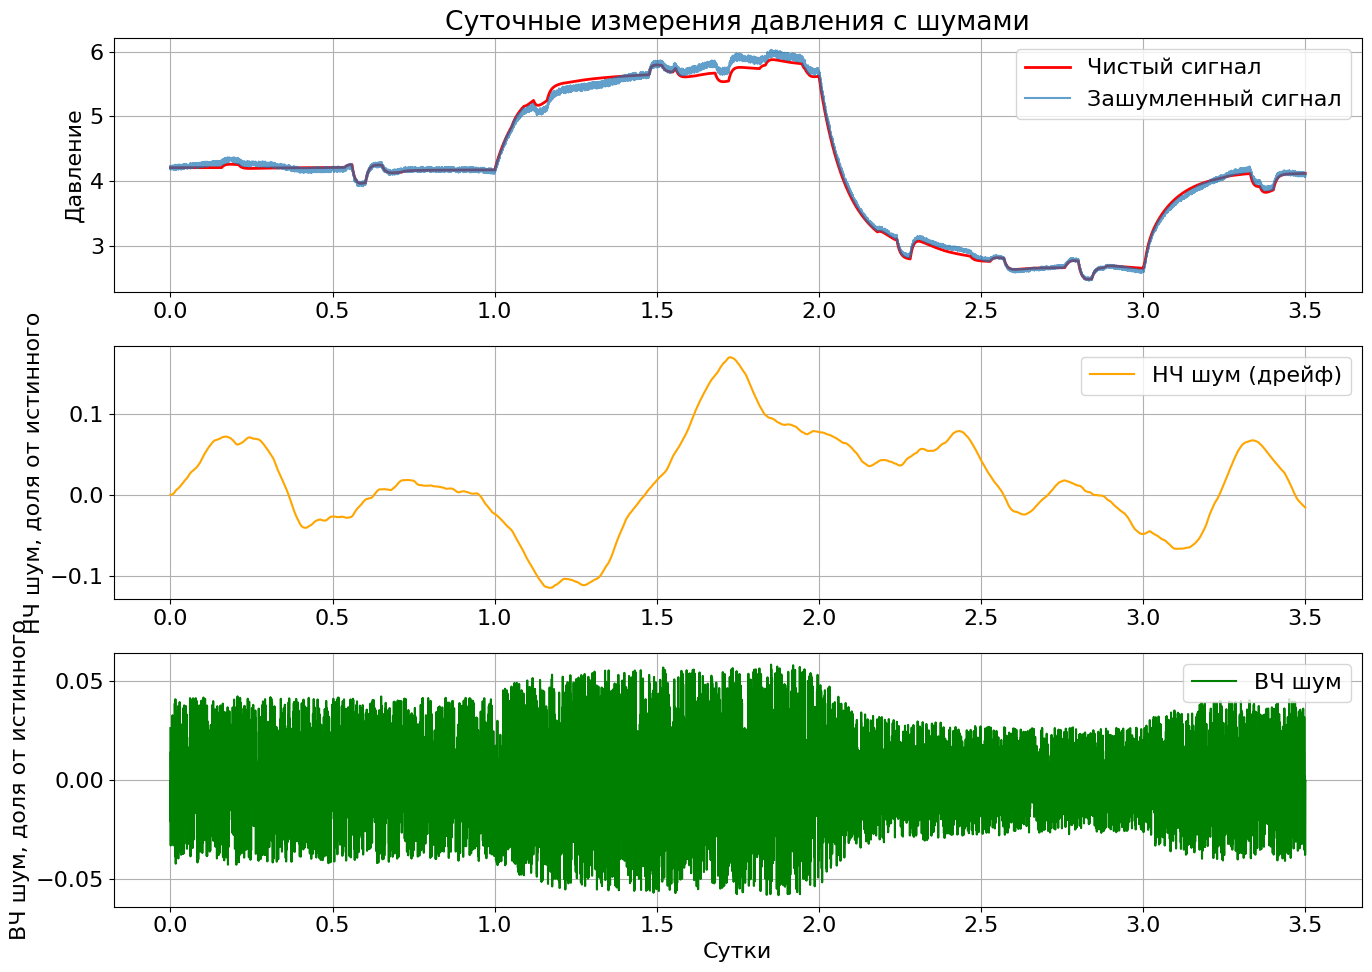

In [1748]:
    # Добавление шумов
    clean_pressure = _p_3

    # Добавление шумов
    noisy_pressure, lf_noise, hf_noise = add_pressure_noise_daily(clean_pressure)

    # Визуализация
    plt.figure(figsize=(14, 10))

    # График давления
    plt.subplot(3, 1, 1)
    plt.plot(df['x'], clean_pressure, label='Чистый сигнал', color='r', lw=2)
    plt.plot(df['x'], noisy_pressure, label='Зашумленный сигнал', alpha=0.7)
    plt.ylabel('Давление')
    plt.title('Суточные измерения давления с шумами')
    plt.legend()
    plt.grid()

    # График НЧ шума
    plt.subplot(3, 1, 2)
    plt.plot(df['x'], lf_noise, label='НЧ шум (дрейф)', color='orange')
    plt.ylabel('НЧ шум, доля от истинного')
    plt.legend()
    plt.grid()

    # График ВЧ шума
    plt.subplot(3, 1, 3)
    plt.plot(df['x'], hf_noise, label='ВЧ шум', color='green')
    plt.ylabel('ВЧ шум, доля от истинного')
    plt.xlabel('Сутки')
    plt.legend()
    plt.grid()


    plt.tight_layout()
    plt.show()

In [1749]:
denominator = 20
ident_k = (k//denominator)
ident_dt = dt * denominator
x_time = df['x'][::denominator]


df_ident = pd.DataFrame({'p_3': [quant[round(index/quant_step)] for index in add_pressure_noise_daily(_p_3)[0][::denominator]],
                         'p_4': [quant[round(index/quant_step)] for index in add_pressure_noise_daily(_p_4)[0][::denominator]],
                         'p_8': [quant[round(index/quant_step)] for index in add_pressure_noise_daily(_p_8)[0][::denominator]],
                         'p_L': [quant[round(index/quant_step)] for index in add_pressure_noise_daily(_p_L)[0][::denominator]],
                         })

# df_ident = pd.DataFrame({'p_3': generate_measurements(_p_3),
#                          'p_4': generate_measurements(_p_4),
#                          'p_8': generate_measurements(_p_8),
#                          'p_L': generate_measurements(_p_L),
#                          'r_U': generate_measurements(_r_U),
#                         })

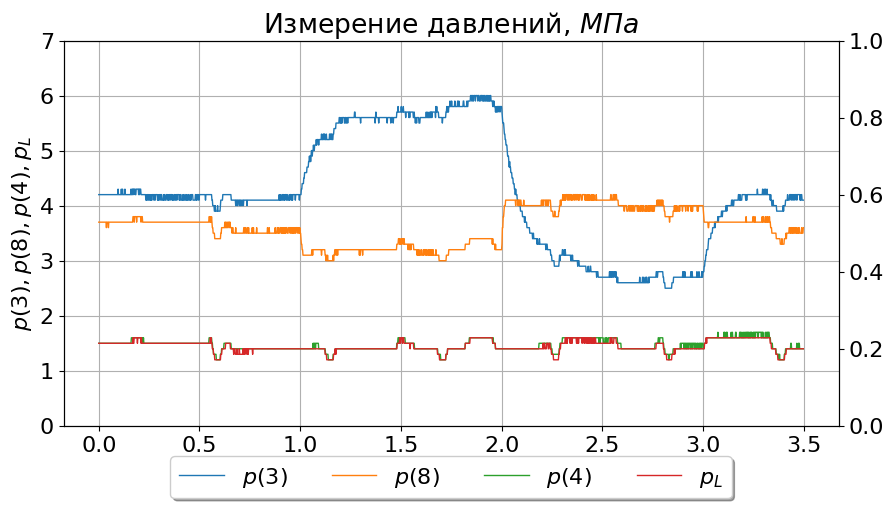

In [1750]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.plot(x_time, df_ident['p_3'], lw=1, label="$p(3)$")
p2, = ax.plot(x_time, df_ident['p_8'], lw=1, label="$p(8)$")
p3, = ax.plot(x_time, df_ident['p_4'], lw=1, label="$p(4)$")
p4, = ax.plot(x_time, df_ident['p_L'], lw=1, label="$p_L$")

ax.set(ylim=(0, 7), xlabel="Сутки", ylabel="$p(3), p(8), p(4),p_L $")
#twin1.set(ylim=(0, 8), ylabel="$p(3)$, $p(8)$")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, handles=[p1, p2, p3, p4])
plt.title('Измерение давлений, $МПа$')
ax.grid()
plt.show()

In [1751]:
# Идентификация через производные

from dataclasses import dataclass, field
from typing import List

@dataclass
class CalculatedValues:
  values: List[float] = field(default_factory=list)

  def add(self, element):
    self.values.append(element)


calc_q = CalculatedValues()
calc__q = CalculatedValues()
calc_q_N = CalculatedValues()
calc_dp = CalculatedValues()
calc_dp_3 = CalculatedValues()
calc_dp_4 = CalculatedValues()
calc_y = CalculatedValues()

for _k in range(ident_k-1):
  q_N = (1/(gamma*r_U))*(df_ident['p_8'][_k+1]-p_L)

  dp_3 = (1/ident_dt)*(df_ident['p_3'][_k+1]-df_ident['p_3'][_k])
  dp_4 = (1/ident_dt)*(df_ident['p_4'][_k+1]-df_ident['p_4'][_k])
  dp = dp_3 - dp_4

  q = q_N + ((S_t/gamma) * dp)

  if _k == 0:
    _q = q
  else:
    _q = _q + (ident_dt/T_2)*(q - _q)

  y = df_ident['p_3'][_k] + gamma*(H_R-H_N+r_K*q)

  calc_q_N.add(q_N)
  calc_q.add(q)
  calc__q.add(_q)
  calc_dp.add(dp)
  calc_dp_3.add(dp_3)
  calc_dp_4.add(dp_4)
  calc_y.add(y)

calc_df = pd.DataFrame({'q_N': calc_q_N.values, 'q': calc_q.values, '_q': calc__q.values, 'dp': calc_dp.values, 'dp_3': calc_dp_3.values, 'dp_4': calc_dp_4.values, 'y': calc_y.values})

In [1752]:
# формируем и заполняем матрицу размерностью 2x2
A = np.empty((3, 3))
A[[0], [0]] = ident_k-1
A[[0], [1]] = sum(calc_q.values)
A[[0], [2]] = sum(calc__q.values)

A[[1], [0]] = sum(calc_q.values)
A[[1], [1]] = sum([value**2 for value in calc_q.values])
A[[1], [2]] = sum([calc__q.values[i]*calc_q.values[i] for i in range(ident_k-1)])

A[[2], [0]] = sum(calc__q.values)
A[[2], [1]] = sum([calc__q.values[i]*calc_q.values[i] for i in range(ident_k-1)])
A[[2], [2]] = sum([value**2 for value in calc__q.values])
A


array([[1.74900000e+03, 1.59041375e+05, 1.58776395e+05],
       [1.59041375e+05, 1.72454823e+07, 1.45782677e+07],
       [1.58776395e+05, 1.45782677e+07, 1.45465130e+07]])

In [1753]:
# находим обратную матрицу
A = np.linalg.inv(A)
# формируем и заполняем матрицу размерностью 3x1
C = np.empty((3, 1))
C[0] = sum(calc_y.values)
C[1] = sum([calc_y.values[i]*calc_q.values[i] for i in range(ident_k-1)])
C[2] = sum([calc_y.values[i]*calc__q.values[i] for i in range(ident_k-1)])
C


array([[  22123.06192707],
       [2000489.88757774],
       [1996999.77224104]])

In [1754]:
# умножаем матрицу на вектор
ww = np.dot(A, C)
ww

array([[ 2.04277068e+01],
       [ 3.02846016e-04],
       [-8.59898754e-02]])

In [1755]:
import scipy
X = np.array([[1 for _ in range(ident_k-1)],
              calc_q.values,
              calc__q.values]).T
y = np.array([calc_y.values]).T
b, squared_error_sum, matrix_rank, SVD_ = scipy.linalg.lstsq(X, y)
print(b)

[[ 2.04277068e+01]
 [ 3.02846016e-04]
 [-8.59898754e-02]]


In [1756]:
A

array([[ 6.27353736e-02,  1.94307781e-06, -6.86709120e-04],
       [ 1.94307781e-06,  3.79510588e-07, -4.01547907e-07],
       [-6.86709120e-04, -4.01547907e-07,  7.96665641e-06]])

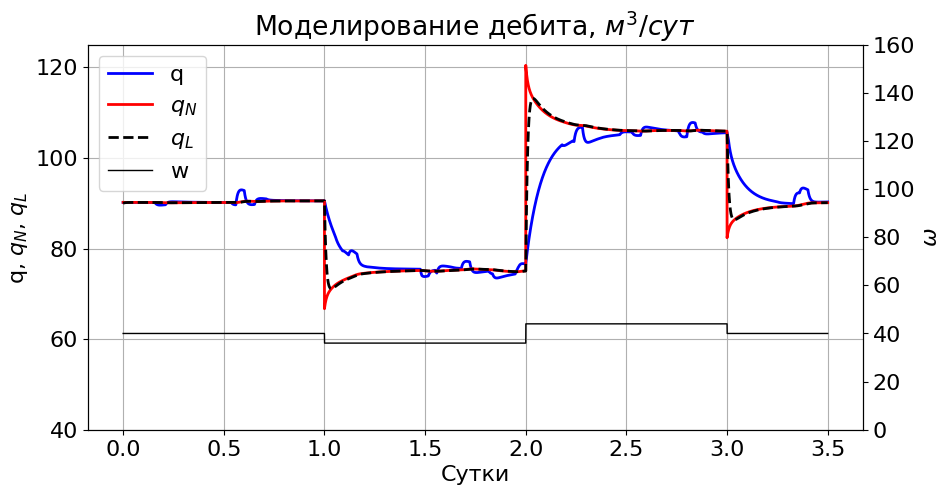

In [1757]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
twin1 = ax.twinx()

plt.rcParams.update({'font.size': 16})

p1, = ax.plot(df['x'], df['q'], 'b', lw=2, label="q")
p2, = ax.plot(df['x'], df['q_N'], 'r', lw=2, label="$q_N$")
p3, = ax.plot(df['x'], df['q_L'], 'k--', lw=2, label="$q_L$")

p4, = twin1.plot(df['x'],  df['u']*40,'k', lw=1, label="w")


ax.set(ylim=(40, 125), xlabel="Сутки", ylabel="q, $q_N$, $q_L$")
twin1.set(ylim=(0, 160), ylabel="$\omega$")

plt.title('Моделирование дебита, $м^3/сут$')

ax.legend(handles=[p1, p2, p3, p4])
ax.grid()
plt.show()

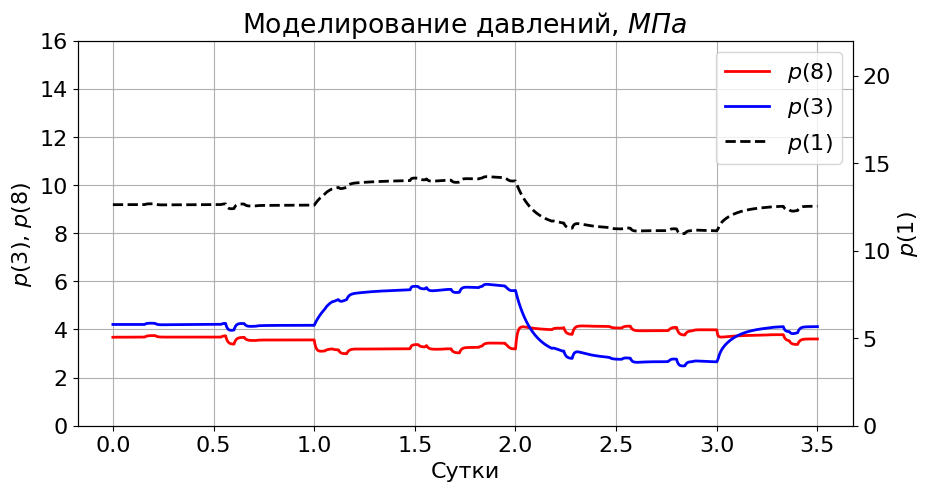

In [1758]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.plot(df['x'], df['p_8'], 'r', lw=2, label="$p(8)$")
p2, = ax.plot(df['x'], df['p_3'], 'b', lw=2, label="$p(3)$")

p3, = twin1.plot(df['x'], df['p_1'], 'k--', lw=2, label="$p(1)$")


ax.set(ylim=(0, 16), xlabel="Сутки", ylabel="$p(3)$, $p(8)$")
twin1.set(ylim=(0, 22), ylabel="$p(1)$")
plt.title('Моделирование давлений, $МПа$')
ax.legend(handles=[p1, p2, p3])
ax.grid()
plt.show()

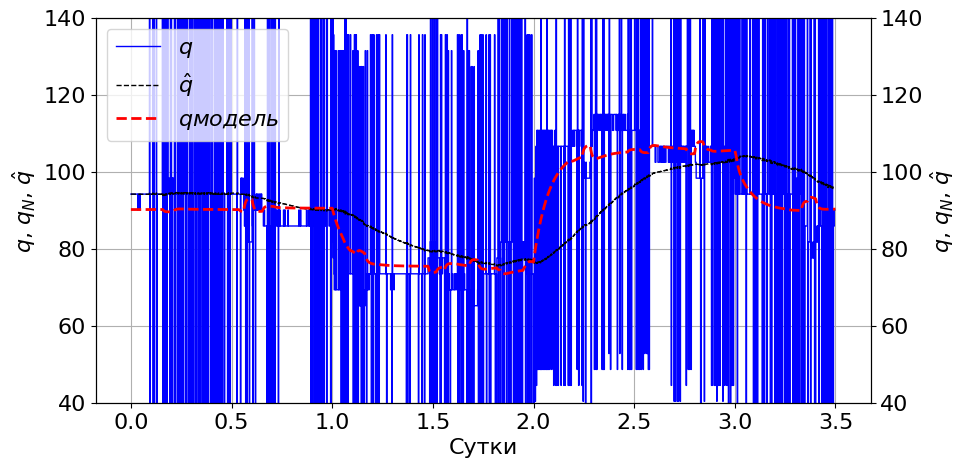

In [1759]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.step(df['x'][:-denominator:denominator], calc_df['q'], 'b', lw=1, label="$q$")
#p2, = ax.plot([index*denominator for index in df['x'][:ident_k-1]], calc_df['q_N'][:ident_k], 'r', lw=2, label="$q_N$")
p3, = ax.step(df['x'][:-denominator:denominator], calc_df['_q'], 'k--', lw=1, label="$\hat{q}$")


p4, = twin1.plot(df['x'], df['q'], 'r--', lw=2, label="$q модель$")
#p5, = twin1.plot(df['x'], df['q_N'], 'r--', lw=1, label="$q_N модель$")


ax.set(ylim=(40, 140), xlabel="Сутки", ylabel="$q$, $q_N$, $\hat{q}$")
twin1.set(ylim=(40, 140), ylabel="$q$, $q_N$, $\hat{q}$")

ax.legend(handles=[p1, p3, p4])
ax.grid()
plt.show()

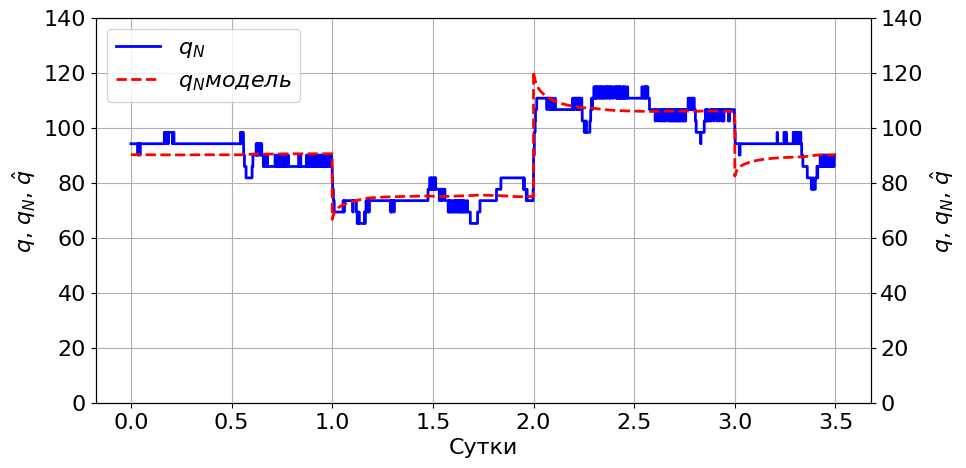

In [1760]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

#p1, = ax.plot([index*denominator for index in df['x'][:ident_k-1]], calc_df['q'][:ident_k], 'b', lw=3, label="$q$")
p2, = ax.step(df['x'][:-denominator:denominator], calc_df['q_N'], 'b', lw=2, label="$q_N$")
#p3, = ax.plot([index*denominator for index in df['x'][:ident_k-1]], calc_df['_q'][:ident_k], 'k--', lw=1, label="$\hat{q}$")


#p4, = twin1.plot(df['x'], df['q'], 'r--', lw=2, label="$q модель$")
p5, = twin1.plot(df['x'], df['q_N'], 'r--', lw=2, label="$q_N модель$")


ax.set(ylim=(0, 140), xlabel="Сутки", ylabel="$q$, $q_N$, $\hat{q}$")
twin1.set(ylim=(0, 140), ylabel="$q$, $q_N$, $\hat{q}$")

ax.legend(handles=[p2, p5])
ax.grid()
plt.show()

In [1761]:
# Идентификация через фильтр

from dataclasses import dataclass, field

@dataclass
class CalculatedValues:
  values: list[float] = field(default_factory=list)

  def add(self, element):
    self.values.append(element)


calc_q_L = CalculatedValues()
calc_dp = CalculatedValues()
calc_dp_t = CalculatedValues()
calc_q_t = CalculatedValues()
calc_p_1_t = CalculatedValues()
calc__q_t = CalculatedValues()

for _k in range(ident_k):

  q_L = (1/(gamma*r_U))*(df_ident['p_8'][_k]-df_ident['p_L'][_k])
  dp = (df_ident['p_3'][_k]-df_ident['p_4'][_k])

  if _k == 0:
    dp_t = dp


  q_t = q_L + ((S_t/(gamma*t_N)) * (dp - dp_t))

  if _k == 0:
    _q_t = q_t
    _p_3 = df_ident['p_3'][0]

  p_1_t = _p_3 + gamma*(H_R-H_N+r_K*q_t)

  calc_q_L.add(q_L)
  calc_dp.add(dp)
  calc_dp_t.add(dp_t)
  calc_q_t.add(q_t)
  calc_p_1_t.add(p_1_t)
  calc__q_t.add(_q_t)

  dp_t = dp_t + (ident_dt/t_N)*(dp - dp_t)
  _q_t = _q_t + (ident_dt/T_2)*(q_t - _q_t)
  _p_3 = _p_3 + (ident_dt/t_N)*(df_ident['p_3'][_k] - _p_3)


calc_df = pd.DataFrame({'q_L': calc_q_L.values,
                        'dp': calc_dp.values,
                        'dp_t': calc_dp_t.values,
                        'q_t': calc_q_t.values,
                        'p_1_t': calc_p_1_t.values,
                        '_q_t': calc__q_t.values,
                        })


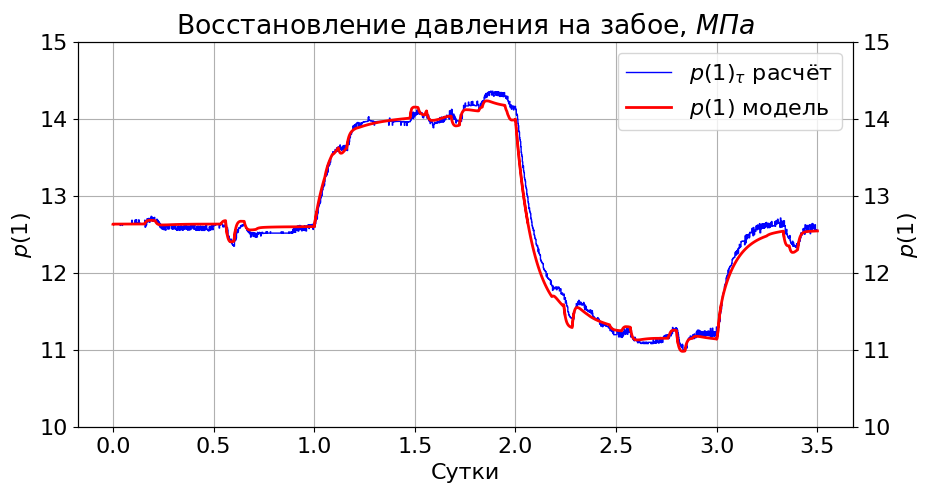

In [1762]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p2, = twin1.step(df['x'], df['p_1'], 'r', lw=2, label="$p(1)$ модель")
p1, = ax.step(x_time, calc_df['p_1_t'], 'b', lw=1, label=r"$p(1)_\tau$ расчёт")


ax.set(ylim=(10, 15), xlabel="Сутки", ylabel="$p(1)$")
twin1.set(ylim=(10, 15), ylabel="$p(1)$")

plt.title('Восстановление давления на забое, $МПа$')

ax.legend(handles=[p1, p2])
ax.grid()
plt.show()

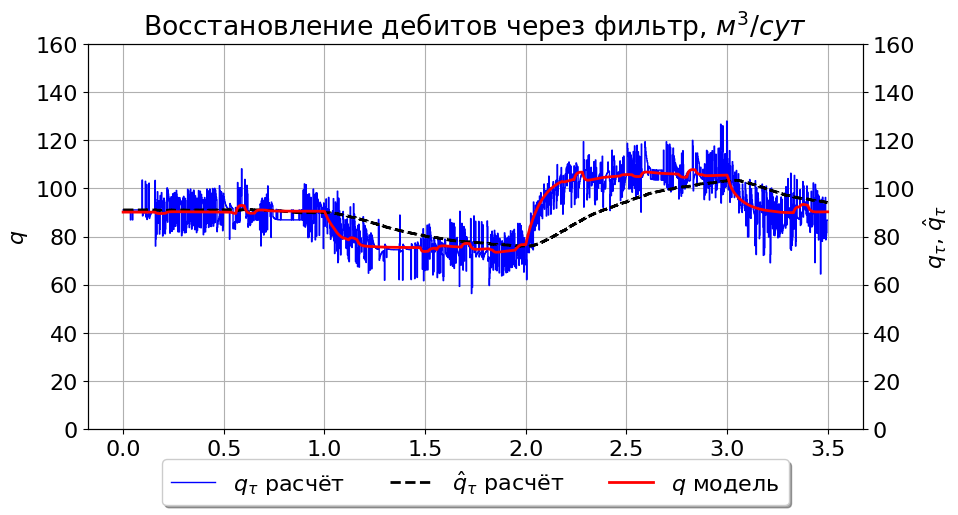

In [1763]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.step(x_time, calc_df['q_t'], 'b', lw=1, label=r"$q_\tau$ расчёт")
p2, = ax.step(x_time, calc_df['_q_t'], 'k--', lw=2, label=r"$\^{q}_\tau$ расчёт")
p3, = twin1.plot(df['x'], df['q'], 'r', lw=2, label="$q$ модель")


ax.set(ylim=(0, 160), xlabel="Сутки", ylabel="$q$")
twin1.set(ylim=(0, 160), ylabel=r"$q_\tau$, $\^{q}_\tau$")

plt.title('Восстановление дебитов через фильтр, $м^3/сут$')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, handles=[p1, p2, p3])
ax.grid()
plt.show()

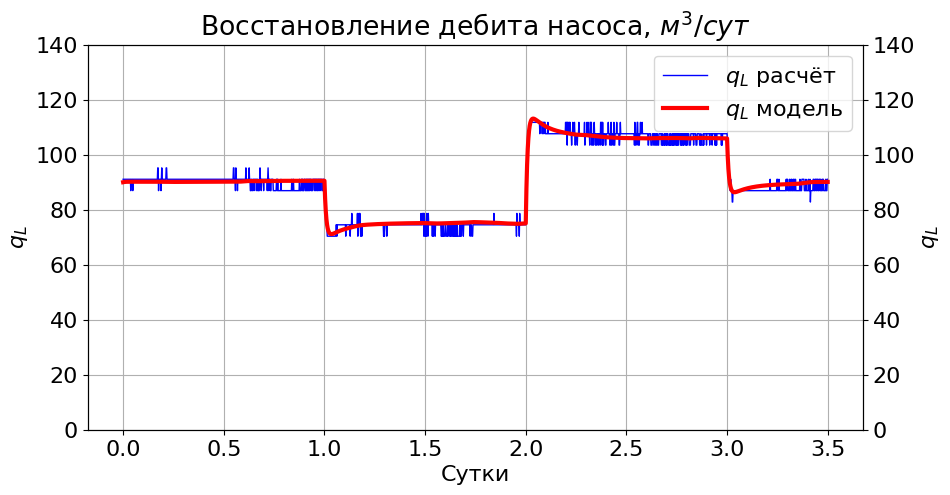

In [1764]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.plot(x_time, calc_df['q_L'], 'b', lw=1, label=r"$q_L$ расчёт")
p2, = ax.plot(df['x'], df['q_L'], 'r', lw=3, label="$q_L$ модель")

ax.set(ylim=(0, 140), xlabel="Сутки", ylabel="$q_L$")
twin1.set(ylim=(0, 140), ylabel=r"$q_L$")

plt.title('Восстановление дебита насоса, $м^3/сут$')

ax.legend(handles=[p1, p2])
ax.grid()
plt.show()

In [1765]:
import scipy
X = np.array([[1 for _ in range(ident_k)],
              calc_q_t.values,
              calc__q_t.values]).T
y = np.array([calc_p_1_t.values]).T
b, squared_error_sum, matrix_rank, SVD_ = scipy.linalg.lstsq(X, y)
print(b)

[[21.38010779]
 [-0.04929738]
 [-0.04780679]]


In [1766]:
p_error = (p_R - b[0][0])/p_R
p_error *= 100
p_error

np.float64(1.2466152799920984)

In [1767]:
r_1_error = (r_1 - b[1][0])/r_1
r_1_error *= 100
r_1_error

np.float64(159.3944381069845)

In [1768]:
r_2_error = (r_2 - b[2][0])/r_2
r_2_error *= 100
r_2_error

np.float64(381.21638965916725)

In [1769]:
k_s = 0
s_indexes = []
s_time = []
d_qt = []

_q_t = calc_df['_q_t']

for i in range(len(_q_t)-1):
  time = i*ident_dt

  if time > 0.8 and time < 0.98 or time > 0.3 and time < 0.4:
    k_s += 1
    d_qt.append(_q_t[i])
    s_indexes.append(i)
    s_time.append(i*ident_dt)

print(k_s)

s_q_t = [calc_q_t.values[i] for i in s_indexes]
s_p_t = [calc_p_1_t.values[i] for i in s_indexes]

m2 = ident_k / k_s


138


In [1770]:
# формируем и заполняем матрицу размерностью 2x2
A1 = np.empty((3, 3))
A1[[0], [0]] = ident_k
A1[[0], [1]] = -sum(calc_q_t.values)
A1[[0], [2]] = -sum(calc__q_t.values)

A1[[1], [0]] = sum(calc_q_t.values)
A1[[1], [1]] = -sum([value**2 for value in calc_q_t.values])
A1[[1], [2]] = -sum([calc__q_t.values[i]*calc_q_t.values[i] for i in range(ident_k)])

A1[[2], [0]] = sum(calc__q_t.values)
A1[[2], [1]] = -sum([calc__q_t.values[i]*calc_q_t.values[i] for i in range(ident_k)])
A1[[2], [2]] = -sum([value**2 for value in calc__q_t.values])

A2 = np.empty((3, 3))
A2[[0], [0]] = k_s
A2[[0], [1]] = -sum(s_q_t)
A2[[0], [2]] = -sum(s_q_t)

A2[[1], [0]] = sum(s_q_t)
A2[[1], [1]] = -sum([value**2 for value in s_q_t])
A2[[1], [2]] = -sum([value**2 for value in s_q_t])

A2[[2], [0]] = sum(s_q_t)
A2[[2], [1]] = -sum([value**2 for value in s_q_t])
A2[[2], [2]] = -sum([value**2 for value in s_q_t])

A2 = np.empty((3, 3))
A2[[0], [0]] = k_s
A2[[0], [1]] = -sum(s_q_t)
A2[[0], [2]] = -sum(s_q_t)

A2[[1], [0]] = sum(s_q_t)
A2[[1], [1]] = -sum([value**2 for value in s_q_t])
A2[[1], [2]] = -sum([value**2 for value in s_q_t])

A2[[2], [0]] = sum(s_q_t)
A2[[2], [1]] = -sum([value**2 for value in s_q_t])
A2[[2], [2]] = -sum([value**2 for value in s_q_t])

A2 = A2 * m2

v_r = r_1/r_2

A3 = np.empty((3, 3))
A3[[0], [0]] = 0
A3[[0], [1]] = 1
A3[[0], [2]] = -v_r

A3[[1], [0]] = 0
A3[[1], [1]] = 1
A3[[1], [2]] = -v_r

A3[[2], [0]] = 0
A3[[2], [1]] = -v_r
A3[[2], [2]] = -v_r * -v_r

A3 = A3 * ident_k

A = A1 + A2 + A3

# находим обратную матрицу
A = np.linalg.inv(A)
# формируем и заполняем матрицу размерностью 3x1
C1 = np.empty((3, 1))
C1[0] = sum(calc_p_1_t.values)
C1[1] = sum([calc_p_1_t.values[i]*calc_q_t.values[i] for i in range(ident_k)])
C1[2] = sum([calc_p_1_t.values[i]*calc__q_t.values[i] for i in range(ident_k)])

C2 = np.empty((3, 1))
C2[0] = sum(s_p_t)
C2[1] = sum([s_p_t[i]*s_q_t[i] for i in range(k_s)])
C2[2] = sum([s_p_t[i]*s_q_t[i] for i in range(k_s)])

C2 = C2 * m2

C = C1 + C2

# умножаем матрицу на вектор
ww = np.dot(A, C)
ww

array([[1.79323293e+01],
       [4.94821218e-02],
       [9.80042684e-03]])

In [1771]:
v_r

4.88235294117647

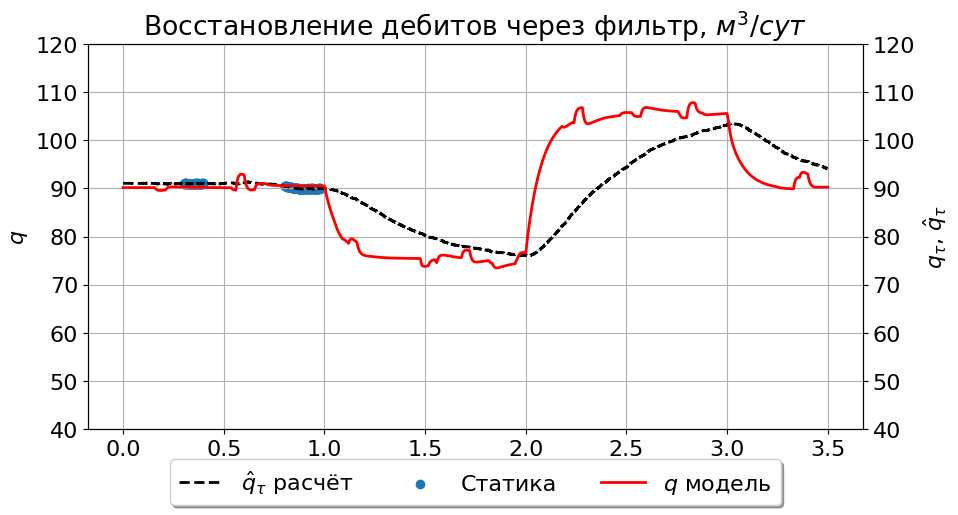

In [1772]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.step(x_time, calc_df['_q_t'], 'k--', lw=2, label=r"$\^{q}_\tau$ расчёт")
p2 = ax.scatter(s_time, d_qt, label=r"Статика")
p3, = twin1.plot(df['x'], df['q'], 'r', lw=2, label="$q$ модель")


ax.set(ylim=(40, 120), xlabel="Сутки", ylabel="$q$")
twin1.set(ylim=(40, 120), ylabel=r"$q_\tau$, $\^{q}_\tau$")

plt.title('Восстановление дебитов через фильтр, $м^3/сут$')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, handles=[p1, p2, p3])
ax.grid()
plt.show()